In [43]:
from pathlib import Path
import os
import zipfile

from einops import rearrange
from skimage.transform import rescale
from spatialdata.transformations import (
    get_transformation, get_transformation_between_coordinate_systems
)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import seaborn as sns
import spatialdata
import tifffile
import yaml
import zarr

In [2]:
from mushroom.registration import bigwarp

Dataset description:

The tutorial dataset consists of 3 serial sections (2 xenium, 1 visium).

The data can be downloaded/loaded from scverse's spatialdata.

In this notebook we will:
1. Download the example data
1. Register the dataset with BigWarp
2. Convert the three registered sections into the format required by mushroom.

First we define a run directory that will store the Mushroom run

In [3]:
run_dir = Path('/data/estorrs/mushroom/data/runs/example_run')
run_dir.mkdir(parents=True, exist_ok=True)

## Data download

Data can be downloaded from [spatialdata](https://spatialdata.scverse.org/en/latest/tutorials/notebooks/datasets/README.html)

Specifically, download the following zarr's and save them to a directory of your choice:

+ [visium_associated_xenium_io](https://s3.embl.de/spatialdata/spatialdata-sandbox/visium_associated_xenium_io.zip)
+ [xenium_rep1_io](https://s3.embl.de/spatialdata/spatialdata-sandbox/xenium_rep1_io.zip)
+ [xenium_rep2_io](https://s3.embl.de/spatialdata/spatialdata-sandbox/xenium_rep2_io.zip)

In [24]:
directory = Path('/data/estorrs/mushroom/data/projects/testing/spatialdata/breast') # directory containing downloaded zarrs
filepaths = [path for path in directory.iterdir() if '.zip' == path.suffix]
filepaths

[PosixPath('/data/estorrs/mushroom/data/projects/testing/spatialdata/breast/visium_associated_xenium_io.zip'),
 PosixPath('/data/estorrs/mushroom/data/projects/testing/spatialdata/breast/xenium_rep2_io.zip'),
 PosixPath('/data/estorrs/mushroom/data/projects/testing/spatialdata/breast/xenium_rep1_io.zip')]

In [25]:
# unzipping zarrs so they can be read by spatialdata
zarrs = []
for path in filepaths:
    inflate_dir = path.parent / path.stem
    with zipfile.ZipFile(path, 'r') as z:
        z.extractall(inflate_dir)
    zarrs.append(inflate_dir / 'data.zarr')
zarrs

[PosixPath('/data/estorrs/mushroom/data/projects/testing/spatialdata/breast/visium_associated_xenium_io/data.zarr'),
 PosixPath('/data/estorrs/mushroom/data/projects/testing/spatialdata/breast/xenium_rep2_io/data.zarr'),
 PosixPath('/data/estorrs/mushroom/data/projects/testing/spatialdata/breast/xenium_rep1_io/data.zarr')]

In [5]:
# assigning section ids for easier reference
sids = ['section0_visium', 'section1_xenium', 'section2_xenium'] # order of the sections
sid_to_path = {
    'section0_visium': Path('/data/estorrs/mushroom/data/projects/testing/spatialdata/breast/visium_associated_xenium_io/data.zarr'),
    'section1_xenium': Path('/data/estorrs/mushroom/data/projects/testing/spatialdata/breast/xenium_rep1_io/data.zarr'),
    'section2_xenium': Path('/data/estorrs/mushroom/data/projects/testing/spatialdata/breast/xenium_rep2_io/data.zarr'),
}

## Registration

Here we register the three sections using keypoint registration with [BigWarp](https://imagej.net/plugins/bigwarp).

However, in practice, any registration method can be used as long as the registered data is in the format mushroom expects as input (see **Input formatting section** of this notebook for more details).

If registering with BigWarp, you will need a working version of [ImageJ/Fiji](https://imagej.net/software/fiji/).

In [6]:
registration_dir = run_dir / 'registration'
registration_dir.mkdir(parents=True, exist_ok=True)
registration_dir

PosixPath('/data/estorrs/mushroom/data/runs/example_run/registration')

We need to make a decision on which section will serve as the target (i.e. fixed) section for registration that all other section will be registered to.

Typically this is the first section in the experiment, but it doesn't have to be.

Note: the resolution of the registered sections will be equal to the resolution of the target section

In [7]:
target_sid = 'section0_visium'

We need to define the resolution for the visium data because the visium section is the section that all other data will be registered to.

In this case, for full resolution visium data, how many microns are there per pixel?

Unfortunately this isn't in the metadata within the zarr anywhere, you just need to know it for your data and find it on the documentation specific to your platform

Specifically for this example, the data resolution can be derived from https://www.10xgenomics.com/support/software/space-ranger/latest/analysis/outputs/spatial-outputs

+ "the estimated pixel size was calculated from the spot diameter for the full resolution image: microns/pixels = 65/89.44 ≈ 0.73"

In [8]:
# visium microns per pixel
target_mpp =  65 / 89.44
target_mpp

0.7267441860465117

Additionally, a downscaling factor needs to be specified. All full-resolution images will be downscaled by this factor during bigwarp registration. (BigWarp tends to be slow with large images, so it helps to downscale images prior to registration. This does not effect the resolution of the final registered spatial data for the sections, it is purely to speed up BigWarp registration)

In [9]:
downscale_factor = 1 / 5 # downscaling by 5x

#### saving unregistered images

In [17]:
def downscale_dask(img, scale):
    """
    Convienence method that takes a dask image and converts downscaled image to numpy array that is uint8.
    
    Image is of shape (n_channels, height, width)
    """
    planes = []
    for plane in img: # iterate over planes seperately in case entire image is to big to fit in RAM
        x = rescale(np.asarray(plane), scale=scale)
        
        # make uint8
        x *= 255
        x = x.astype(np.uint8)
        
        planes.append(x)
    return np.stack(planes)

###### visium

In [18]:
sid = 'section0_visium'
sdata = spatialdata.read_zarr(
    sid_to_path[sid]
)
sdata

SpatialData object with:
├── Images
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': MultiscaleSpatialImage[cyx] (3, 21571, 19505), (3, 10785, 9752), (3, 5392, 4876), (3, 2696, 2438), (3, 1348, 1219)
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_hires_image': SpatialImage[cyx] (3, 2000, 1809)
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_lowres_image': SpatialImage[cyx] (3, 600, 543)
├── Shapes
│     └── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (4992, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (4992, 18085)
with coordinate systems:
▸ 'downscaled_hires', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_hires_image (Images), CytAssist_FFPE_Human_Breast_Cancer (Shapes)
▸ 'downscaled_lowres', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_lowres_image (Images), CytAssist_FFPE_Human_Breast_Cancer (Shapes)
▸ 'global', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_full_image (Images), CytAssist_FFPE_Human_Breast_Cancer (Shap

In [19]:
sdata.images['CytAssist_FFPE_Human_Breast_Cancer_full_image']

DataTree('None', parent=None)
├── DataTree('scale0')
│       Dimensions:  (y: 21571, x: 19505, c: 3)
│       Coordinates:
│         * y        (y) float64 0.5 1.5 2.5 3.5 ... 2.157e+04 2.157e+04 2.157e+04
│         * x        (x) float64 0.5 1.5 2.5 3.5 ... 1.95e+04 1.95e+04 1.95e+04 1.95e+04
│       Dimensions without coordinates: c
│       Data variables:
│           image    (c, y, x) uint8 dask.array<chunksize=(3, 256, 256), meta=np.ndarray>
├── DataTree('scale1')
│       Dimensions:  (y: 10785, x: 9752, c: 3)
│       Coordinates:
│         * y        (y) float64 1.0 3.0 5.0 7.0 ... 2.157e+04 2.157e+04 2.157e+04
│         * x        (x) float64 1.0 3.0 5.0 7.0 ... 1.95e+04 1.95e+04 1.95e+04 1.95e+04
│       Dimensions without coordinates: c
│       Data variables:
│           image    (c, y, x) uint8 dask.array<chunksize=(3, 256, 256), meta=np.ndarray>
├── DataTree('scale2')
│       Dimensions:  (y: 5392, x: 4876, c: 3)
│       Coordinates:
│         * y        (y) float64 2.0 6.001 10.0 14.0 ... 2.156e+04 2.156e+04 2.157e+04
│         * x        (x) float64 2.0 6.0 10.0 14.0 ... 1.949e+04 1.95e+04 1.95e+04
│       Dimensions without coordinates: c
│       Data variables:
│           image    (c, y, x) uint8 dask.array<chunksize=(3, 256, 256), meta=np.ndarray>
├── DataTree('scale3')
│       Dimensions:  (y: 2696, x: 2438, c: 3)
│       Coordinates:
│         * y        (y) float64 4.001 12.0 20.0 28.0 ... 2.155e+04 2.156e+04 2.157e+04
│         * x        (x) float64 4.0 12.0 20.0 28.0 ... 1.948e+04 1.949e+04 1.95e+04
│       Dimensions without coordinates: c
│       Data variables:
│           image    (c, y, x) uint8 dask.array<chunksize=(3, 256, 256), meta=np.ndarray>
└── DataTree('scale4')
        Dimensions:  (y: 1348, x: 1219, c: 3)
        Coordinates:
          * y        (y) float64 8.001 24.0 40.01 ... 2.153e+04 2.155e+04 2.156e+04
          * x        (x) float64 8.0 24.0 40.0 56.0 ... 1.946e+04 1.948e+04 1.95e+04
        Dimensions without coordinates: c
        Data variables:
            image    (c, y, x) uint8 dask.array<chunksize=(3, 256, 256), meta=np.ndarray>

In [20]:
# grab fullres H&E image
fullres = sdata.images['CytAssist_FFPE_Human_Breast_Cancer_full_image']['scale0']
fullres

DataTree('scale0', parent="None")
    Dimensions:  (y: 21571, x: 19505, c: 3)
    Coordinates:
      * y        (y) float64 0.5 1.5 2.5 3.5 ... 2.157e+04 2.157e+04 2.157e+04
      * x        (x) float64 0.5 1.5 2.5 3.5 ... 1.95e+04 1.95e+04 1.95e+04 1.95e+04
    Dimensions without coordinates: c
    Data variables:
        image    (c, y, x) uint8 dask.array<chunksize=(3, 256, 256), meta=np.ndarray>

In [21]:
img = fullres.image
img

<xarray.DataArray 'image' (c: 3, y: 21571, x: 19505)>
dask.array<from-zarr, shape=(3, 21571, 19505), dtype=uint8, chunksize=(3, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 0.5 1.5 2.5 3.5 ... 2.157e+04 2.157e+04 2.157e+04
  * x        (x) float64 0.5 1.5 2.5 3.5 ... 1.95e+04 1.95e+04 1.95e+04 1.95e+04
Dimensions without coordinates: c
Attributes:
    transform:  {'global': Identity }

In [22]:
# rull resolution target size
target_size = img.shape[1], img.shape[2]
target_size

(21571, 19505)

In [47]:
# downscale for faster bigwarp registration
scaled = downscale_dask(img, downscale_factor)
scaled.shape

(3, 4314, 3901)

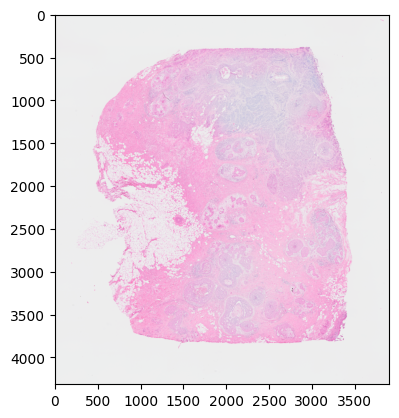

In [79]:
plt.imshow(rearrange(scaled, 'c h w -> h w c'))

In [52]:
# save as tif
tifffile.imwrite(registration_dir / f'{sid}_unregistered.tif', scaled)

###### xenium


In [40]:
# again, unfortunately this info isn't already in the Xenium SpatialData object, but according to documentation
# the cell coordinates are in microns (i.e. 1 micron per pixel)
# the morphology focus image (which we are using for registration) is .2125 microns per pixel
# we need this information later because we will have to scale the coordinates up to the same resolution as the morphology focus image
xenium_corrdinates_mpp =  1.
xenium_morphology_focus_mpp = .2125 

In [91]:
# taking a look at the data contents
sid = 'section1_xenium'
sdata = spatialdata.read_zarr(
    sid_to_path[sid]
)
sdata

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SpatialData object with:
├── Images
│     ├── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
│     └── 'morphology_mip': MultiscaleSpatialImage[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
├── Points
│     └── 'transcripts': DataFrame with shape: (42638083, 8) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (167780, 1) (2D shapes)
│     └── 'cell_circles': GeoDataFrame shape: (167780, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (167780, 313)
with coordinate systems:
▸ 'global', with elements:
        morphology_focus (Images), morphology_mip (Images), transcripts (Points), cell_boundaries (Shapes), cell_circles (Shapes)

Xenium data loaded with SpatialData library is in roughly the same format as visium data (the fullres image is just named differently as seen above)

Here we iterate over the two xenium sections and save the downsampled, unregistered images

In [108]:
xenium_sids = [sid for sid in sids if 'xenium' in sid]
xenium_sids

['section1_xenium', 'section2_xenium']

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


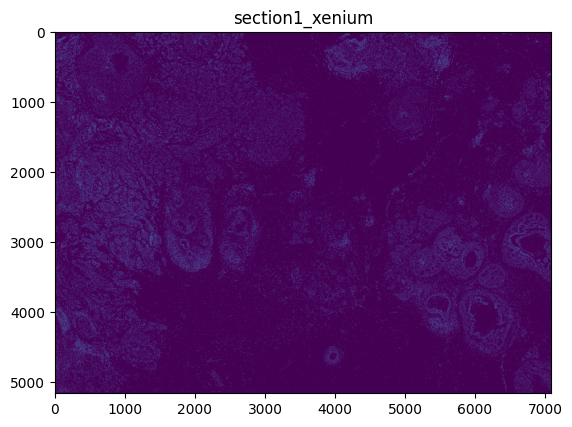

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


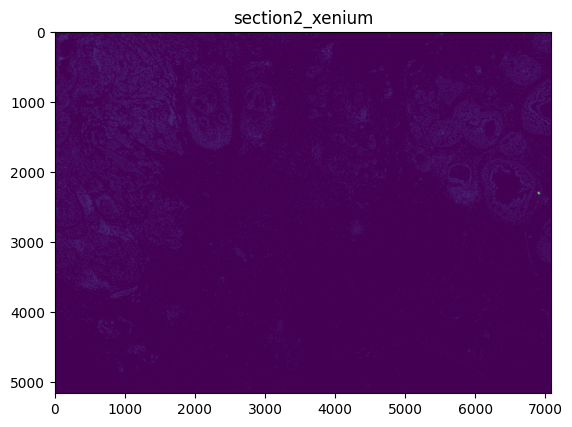

In [97]:
for sid in xenium_sids:
    sdata = spatialdata.read_zarr(sid_to_path[sid])
    
    # get image
    fullres = sdata.images['morphology_focus']['scale0']
    img = fullres.image
    
    # downscale
    scaled = downscale_dask(img, downscale_factor)
    
    # show it
    plt.imshow(rearrange(scaled, 'c h w -> h w c'))
    plt.title(sid)
    plt.show()
    
    # save
    tifffile.imwrite(registration_dir / f'{sid}_unregistered.tif', scaled)

## Generating dense displacement field (DDF) with BigWarp

First, you will need to install [ImageJ/Fiji](https://imagej.net/software/fiji/).

Then follow the instructions in [this video](https://zenodo.org/records/12611046)

**IMPORTANT NOTE**: In the video when registering the second xenium section I made a mistake and stopped the video before saving the displacement field. Make sure you save the second displacement field in the same manner as the first xenium section (i.e. as section2_xenium_ddf.tif)

Make sure you save the warp/dense displacement fields in the manner described in the video for the rest of the tutorial to work correctly. (i.e. _ddf.tif)

## Register full-resolution sections

After saving the dense displacement field, we can register the full resolution data

In [10]:
# we should see two DDFs, one for each xenium section
filepaths = [path for path in registration_dir.iterdir() if '_ddf.tif' in path.name]
filepaths

[PosixPath('/data/estorrs/mushroom/data/runs/example_run/registration/section2_xenium_ddf.tif'),
 PosixPath('/data/estorrs/mushroom/data/runs/example_run/registration/section1_xenium_ddf.tif')]

In [11]:
target_sid

'section0_visium'

Here we load the DDF for each section that needs to be registered

In [12]:
sid_to_ddf = {}

for sid in sids:
    path = sid_to_path[sid]
    
    if sid != target_sid: # initial registration target section will not have ddf
        ddf_fp = registration_dir / f'{sid}_ddf.tif'
        assert ddf_fp.exists, f'Expected a ddf/warp field file at {ddf_fp}, but no file was found.'

        # returns a pytorch tensor of shape (2, height, width)
        # height and width will be the height and width of the target section at full resolution
        # the first channel is height displacement, and the second is width displacement
        
        ddf = bigwarp.read_bigwarp_warp_field(ddf_fp, downscale_factor)
        sid_to_ddf[sid] = ddf

sid_to_ddf.keys()

dict_keys(['section1_xenium', 'section2_xenium'])

In [13]:
ddf = next(iter(sid_to_ddf.values()))
ddf.shape

torch.Size([2, 21570, 19505])

Below we register each section.

In [14]:
registered_dir = run_dir / 'registered'
registered_dir.mkdir(parents=True, exist_ok=True)
registered_dir

PosixPath('/data/estorrs/mushroom/data/runs/example_run/registered')

In [15]:
def patch_adata(adata, fullres_size, dtype, sf=.1):
    """
    Only necessary for objects loaded from SpatialData .zarr
    
    SpatialData .zarr does not keep things in same format as original scanpy .h5ad Visium/xenium objects.
    
    Need to patch the adata to add a hires image in same place that scanpy/squidpy do as it is used later by mushroom to calculate the full resolution size of the section
    """
    size = (np.asarray(fullres_size) * sf).astype(int)
    if dtype in ['xenium', 'cosmx']:
        blank = np.zeros((size[0], size[1]))
    else:
        blank = np.zeros((size[0], size[1], 3))

    adata.uns['spatial'] = {
        'key': {
            'images': {'hires': blank},
            'scalefactors': {
                'tissue_hires_scalef': sf,
                'spot_diameter_fullres': 89.44,
            }
        }
    }
    return adata

In [34]:
for sid in sids:
    print(sid)
    path = sid_to_path[sid]
    dtype = sid.split('_')[1]
    sdata = spatialdata.read_zarr(path)
    adata = sdata.tables['table']
    adata = patch_adata(adata, target_size, dtype)

    # register if not target section
    if sid != target_sid:
        # grab section ddf
        ddf = sid_to_ddf[sid]
        
        # we need to scale the cell coordinates to get them to the same resolution as the morphology focus image that was used for registration
        coordinate_sf = xenium_corrdinates_mpp / xenium_morphology_focus_mpp

        # register the xenium data
        adata = bigwarp.register_xenium(
            adata, ddf, resolution=target_mpp, coordinate_sf=coordinate_sf
        )
    
    # write registered data
    adata.write_h5ad(registered_dir / f'{sid}.h5ad')

section0_visium
section1_xenium


/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/data/estorrs/mushroom/mushroom/registration/bigwarp.py:175: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  new.obsm['spatial'] = transformed[:, [1, 0]].numpy()
/data/estorrs/mushroom/mushroom/registration/bigwarp.py:185: RuntimeWarning: invalid value encountered in divide
  d['images']['hires'] = warped_hires / warped_hires.max() # numpy conversion has slight overflow issue


section2_xenium


/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/data/estorrs/mushroom/mushroom/registration/bigwarp.py:175: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  new.obsm['spatial'] = transformed[:, [1, 0]].numpy()
/data/estorrs/mushroom/mushroom/registration/bigwarp.py:185: RuntimeWarning: invalid value encountered in divide
  d['images']['hires'] = warped_hires / warped_hires.max() # numpy conversion has slight overflow issue


In [35]:
filepaths = [path for path in registered_dir.iterdir()]
filepaths

[PosixPath('/data/estorrs/mushroom/data/runs/example_run/registered/section1_xenium.h5ad'),
 PosixPath('/data/estorrs/mushroom/data/runs/example_run/registered/section2_xenium.h5ad'),
 PosixPath('/data/estorrs/mushroom/data/runs/example_run/registered/section0_visium.h5ad')]

Inspecting the registered sections to make sure registration was done correctly

In [36]:
a1 = sc.read_h5ad(registered_dir / 'section0_visium.h5ad')
a2 = sc.read_h5ad(registered_dir / 'section1_xenium.h5ad')
a1, a2

(AnnData object with n_obs × n_vars = 4992 × 18085
     obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'spatial', 'spatialdata_attrs'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 100346 × 313
     obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'ppm', 'spatial', 'spatialdata_attrs'
     obsm: 'spatial', 'spatial_original')

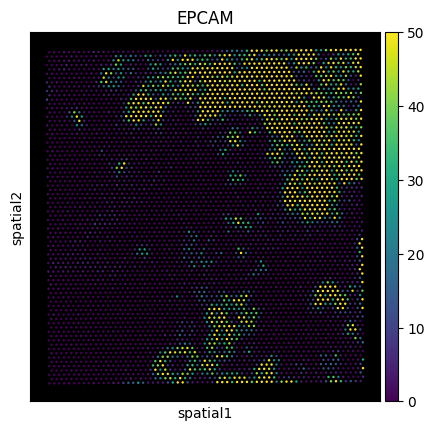

In [37]:
# picking an epithelial marker gene to visualize
sc.pl.spatial(a1, color='EPCAM', vmax=50)

(5287.45, 17003.55, 18770.65, 3268.35)

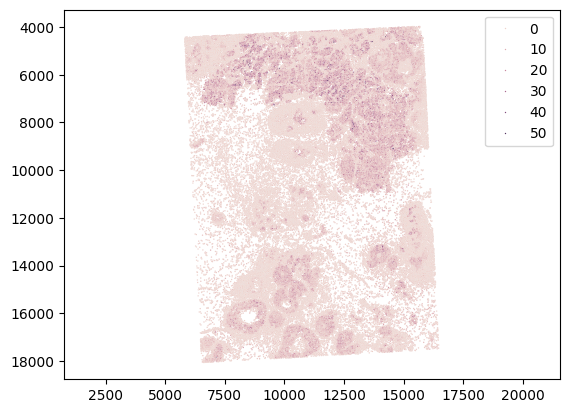

In [38]:
X = a2.obsm['spatial']
sns.scatterplot(x=X[:, 0], y=X[:, 1], s=1., hue=a2[:, 'EPCAM'].X.toarray().flatten())
plt.gca().invert_yaxis()
plt.axis('equal')

(3036.25, 17110.75, 18770.65, 3268.35)

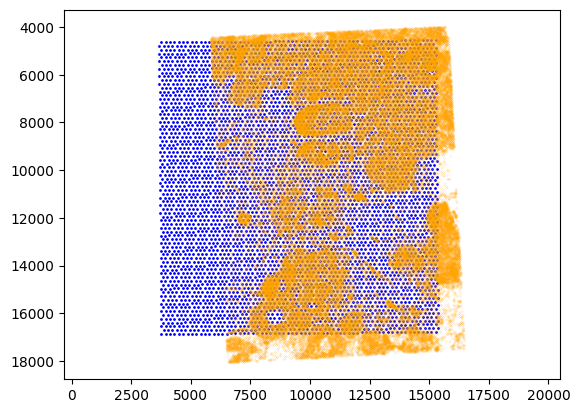

In [41]:
# plotting points on same axis
X = a1.obsm['spatial']
plt.scatter(x=X[:, 0], y=X[:, 1], s=1., c='blue')

X = a2.obsm['spatial']
plt.scatter(x=X[:, 0], y=X[:, 1], s=.01, c='orange')

plt.gca().invert_yaxis()
plt.axis('equal')

(2117.5, 17154.5, 18788.75, 2888.25)

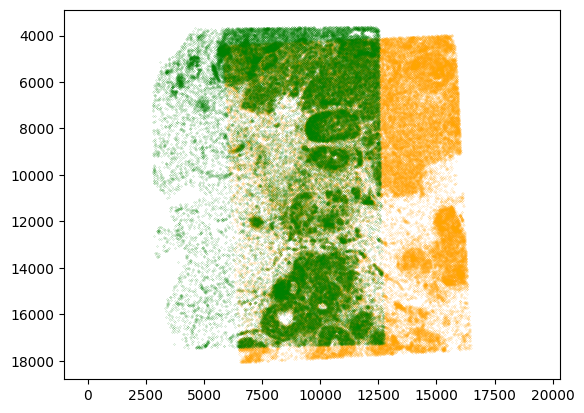

In [42]:
# also checking section 2
a3 = sc.read_h5ad(registered_dir / 'section2_xenium.h5ad')

X = a2.obsm['spatial']
plt.scatter(x=X[:, 0], y=X[:, 1], s=.01, c='orange')

X = a3.obsm['spatial']
plt.scatter(x=X[:, 0], y=X[:, 1], s=.01, c='green')

plt.gca().invert_yaxis()
plt.axis('equal')


#### registering other data types

In this example the xenium sections are the only ones being registered, but what if you need to register other data types? Or register data that is not in SpatialData .zarr format?

Mushroom provides several convience functions for registering the following data types:
+ H&E
+ Multiplex OME-TIF images
+ Xenium
+ Visium
+ CoxMx

If needed for your data, you can read in, register, and write images with the following methods

###### H&E

In [ ]:
# from mushroom.data.he import read_he
# from einops import rearrange

# ## load image
# img = read_he('path/to/he.tif') # will read .tif or .svs, returns numpy array of shape (height, width, 3) or whichever access order is specified by in put .tif

# ## register image
# img = rearrange(img, 'h w c -> c h w') # bigwarp registration method needs axes ordered as (c, h, w)
# img = bigwarp.register_he(img, ddf)
# img = rearrange(img, 'c h w -> h w c') # order axes back to (h, w, c)

# ## write basic output image
# tifffile.imwrite(
#     '/path/to/output.tif',
#     data=rearrange(img, 'c h w -> h w c'),
#     resolution=(target_mpp, target_mpp), # not really a valid spot to stick this, but works as a quick fix to keep resolution info in file
#     compression='LZW',
#     metadata={
#         'axes': 'YXC',
#         'unit': 'um', # assumes microns as unit, can change to whatever unit
#     }
# )

###### multiplex OME-TIF

In [ ]:
# from mushroom.data.multiplex import extract_ome_tiff

# ## currently loads all data into RAM
# ## it's on the TODO list to load in data with dask or zarr to avoid memory issues, but for now everything is loaded in at once.
# channels, data = extract_ome_tiff('path/to/multiplex.ome.tif', as_dict=False) # returns list of channel names and numpy array of shape (n_channels, height, width)

# ## register
# data = bigwarp.register_multiplex(data, ddf)

# ## write ome-tif
# multiplex.write_basic_ome_tiff(
#     'path/to/output.ome.tif',
#     data, channels, pix_per_micron=target_mpp
# )

###### Visium

In [ ]:
# from mushroom.data.visium import adata_from_visium

# ## read data from 10x visium directory or .h5ad file
# adata = adata_from_visium('path/to/visium/directory') # or .h5ad file

# ## register points in .obsm (i.e. spots) and hires/lowres H&E images in .uns['spatial']
# adata = bigwarp.register_visium(
#     adata, ddf, resolution=target_mpp
# )

# ## write output
# adata.write_h5ad('path/to/output.h5ad')

###### Xenium

In [ ]:
# from mushroom.data.xenium import adata_from_xenium

# ## read data from 10x xenium directory or .h5ad file
# adata = adata_from_xenium('/path/to/xenium/directory') # or .h5ad file

# ## register points in .obsm (i.e. segmented cells) and adds hires DAPI image in .uns['spatial']
# adata = bigwarp.register_xenium(
#     adata, ddf, resolution=target_mpp
# )

# ## write output
# adata.write_h5ad('path/to/output.h5ad')

###### CosMx

In [ ]:
# from mushroom.data.cosmx import adata_from_cosmx

# ## read data from cosmx output directory or .h5ad file
# adata = adata_from_cosmx('/path/to/cosmx/directory') # or .h5ad file

# ## register points in .obsm (i.e. segmented cells)
# adata = bigwarp.register_cosmx(
#     adata, ddf, resolution=target_mpp
# )

# ## write output
# adata.write_h5ad('path/to/output.h5ad')

#### registering auxilliary data

You may also have other data that you would like to register.

For example, if you had cell coordinates for a multiplex image, etc.

We can also register that data using the warp_pts function

In [53]:
# 2D array of coordinates
# first column is height (Y), second column is width (X)
# the coordinates MUST be at the same resolution as the full resolution image used during registration
pts = np.asarray([
    [12000, 15000],
    [1000, 2000],
    [10000, 12345]
])
# the sections DDF
ddf = sid_to_ddf['section1_xenium']

# returns the registered points that were successfully registered and a mask where False indicates that a point was not mapped/fell outside the bounds of the registered image
registered_pts, mask = bigwarp.warp_pts(pts, ddf)

# changing back to numpy
registered_pts, mask = registered_pts.numpy(), mask.numpy()
registered_pts.shape, mask.shape

((1, 2), (3,))

In [54]:
registered_pts # only the third point was successfully registered

array([[ 8868, 12150]])

In [55]:
mask

array([False, False,  True])

## Formatting sections according to mushroom specifications

Mushroom expects metadata for sections to be in a particular format.

Here we create a dictionary that meets Mushroom section formatting guidelines.

In [48]:
filepaths = [path for path in registered_dir.iterdir() if '.yaml' != path.suffix]
sid_to_registered_path = {
    path.stem:path for path in filepaths
}
sid_to_registered_path

{'section1_xenium': PosixPath('/data/estorrs/mushroom/data/runs/example_run/registered/section1_xenium.h5ad'),
 'section2_xenium': PosixPath('/data/estorrs/mushroom/data/runs/example_run/registered/section2_xenium.h5ad'),
 'section0_visium': PosixPath('/data/estorrs/mushroom/data/runs/example_run/registered/section0_visium.h5ad')}

The data config is a dictionary with the following keys:
+ target_sid - section ID of the section used as the initial target (i.e. fixed) image.
+ resolution - resolution of the target section (and therefore all registered sections).
+ sections - list of section objects

A section object has the following keys
+ sid - section ID
+ position - position (in z direction) of the section in the tissue block. Usually in microns, but could be any unit.
+ data - list of data objects. A section can have multiple data objects. (such as H&E and visium expression, etc.). If this is the case, all data types for that section must be at the same resolution. For example, for visium data that has expression and H&E, the H&E image must be at the same level of resolution as the spot coordinates stored in the anndata .obsm attribute.

A data object has the following keys
+ dtype - data type identifier. MUST be "he", "multiplex", "xenium", "visium", "cosmx", or "points".
  + he - H&E image that is a 3 channel .tif or .svs file
  + multiplex - Multiplex OME-TIF file
  + xenium - 10X xenium output directory or scanpy/squidpy .h5ad file
  + visium - 10X visium output directory or scanpy/squidpy .h5ad file
  + cosmx - CosMx output directory or scanpy/squidpy .h5ad file
  + points - A scanpy/squidpy AnnData object with coordinates stored in .obsm attribute
+ filepath - Filepath to data. See above bullet for acceptable files.


See the example below for a correct config

In [49]:
data_config = {
    'target_sid': target_sid, # section ID of the section used as the initial target (i.e. fixed) image.
    'resolution': target_mpp, # resolution of the target section
    'sections': [ # list of all sections in serial section experiment
        { # section object
            'sid': 'section0_visium', # name if tissue section, must be unique across all sections
            'position': 0, # position of section (usually in microns) in z-direction on tissue block
            'data': [ # all data types present for a section, for example both H&E and Visium expression data could be present for same section of tissue (in this case we are only using expression)
                { # data object
                    'dtype': 'visium', # MUST be "he", "multiplex", "xenium", "visium", "cosmx", "points"
                    'filepath': str(sid_to_registered_path['section0_visium'].absolute()) # absolute filepath to registered data
                },
            ] 
        },
        {
            'sid': 'section1_xenium',
            'position': 5, # FFPE sections are usually 5 microns apart
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': str(sid_to_registered_path['section1_xenium'].absolute())
                },
            ] 
        },
        {
            'sid': 'section2_xenium',
            'position': 10, # FFPE sections are usually 5 microns apart
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': str(sid_to_registered_path['section2_xenium'].absolute())
                },
            ] 
        },
    ]
}
data_config

{'target_sid': 'section0_visium',
 'resolution': 0.7267441860465117,
 'sections': [{'sid': 'section0_visium',
   'position': 0,
   'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/runs/example_run/registered/section0_visium.h5ad'}]},
  {'sid': 'section1_xenium',
   'position': 5,
   'data': [{'dtype': 'xenium',
     'filepath': '/data/estorrs/mushroom/data/runs/example_run/registered/section1_xenium.h5ad'}]},
  {'sid': 'section2_xenium',
   'position': 10,
   'data': [{'dtype': 'xenium',
     'filepath': '/data/estorrs/mushroom/data/runs/example_run/registered/section2_xenium.h5ad'}]}]}

Saving the config as a yaml file

In [50]:
yaml.safe_dump(data_config, open(registered_dir / 'data.yaml', 'w'))